<h1 style="text-align: center; font-size: 2.5em; padding: 30px;">Weryfikacja mojego algorytmu Algen</h1>
<h4 style="color: gray;">


Podejście:<br>
<ol>
    <li> Obliczenie współczynników za pomocą regresji liniowej z pakietu scikit-learn
    <li> Obliczenie współczynników za pomocą macierzy pseudo-inwersji Moore'a-Penrose'a
    </ol>
</h4>

## 1. Metoda regresji liniowej z scikit-learn 

Tu wykorzystałem pandas do wczytania danych z CSV (większy plik).<br>
Następnie standardowo <b>sklearn.linear_model.LinearRegression</b> oraz <b>sklearn.metrics.mean_squared_error</b>


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
try:
    algen_data = pd.read_csv("algen_data.csv", names = ["target", "a", "b"])
    print("Dane zostały poprawnie wczytane. \nShape algen_data to: %s" % str(algen_data.shape))
except:
    print("Nie udało się wczytać danych, sprawdź lolalizację pliku z danymi")

Dane zostały poprawnie wczytane. 
Shape algen_data to: (3500, 3)


In [3]:
algen_data.head(5)

,target,a,b
0,26.230272,0.133901,3.904581
1,26.873981,-0.056517,5.437450
2,27.950209,0.581439,8.123199
3,28.808394,1.218853,10.921779
4,30.064250,1.050206,15.251387


In [4]:
X = algen_data[["a", "b"]]
X[:5]

,a,b
0,0.133901,3.904581
1,-0.056517,5.437450
2,0.581439,8.123199
3,1.218853,10.921779
4,1.050206,15.251387


In [5]:
y = algen_data[['target']]
y[:5]

,target
0,26.230272
1,26.873981
2,27.950209
3,28.808394
4,30.064250


In [6]:
# zmienna a
np.array(X)[:, :1]

array([[  1.33900875e-01],
       [ -5.65171053e-02],
       [  5.81439054e-01],
       ..., 
       [  8.74484510e+02],
       [  8.74609906e+02],
       [  8.75324866e+02]])

In [7]:
# zmienna b
np.array(X)[:, 1:]

array([[  3.90458096e+00],
       [  5.43744991e+00],
       [  8.12319888e+00],
       ..., 
       [  1.04944779e+04],
       [  1.04966604e+04],
       [  1.05003135e+04]])

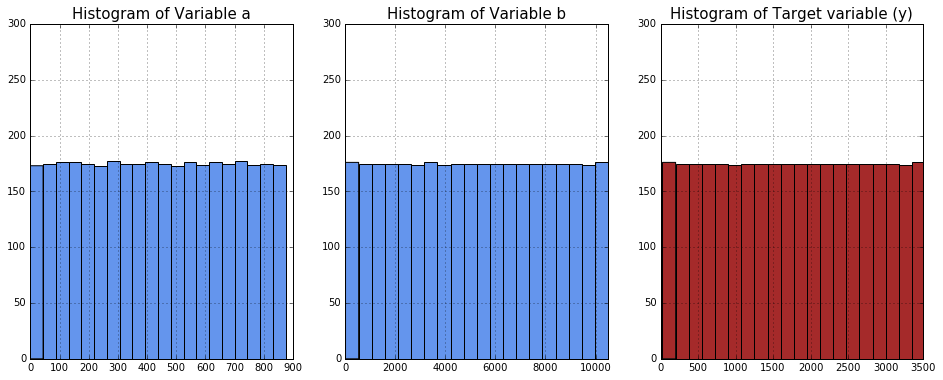

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=[16, 6])

ax[0].hist(X.values[:, :1], bins=20, color="cornflowerblue")
ax[0].set_ylim(0, 300)
ax[0].set_xlim(0, 900)
ax[0].set_title("Histogram of Variable a", fontsize="15")
ax[0].grid(True)

ax[1].hist(X.values[:, 1:], bins=20, color="cornflowerblue")
ax[1].set_ylim(0, 300)
ax[1].set_xlim(0, 10500)
ax[1].set_title("Histogram of Variable b", fontsize="15")
ax[1].grid(True)

ax[2].hist(y.values, bins=20, color="brown")
ax[2].set_ylim(0, 300)
ax[2].set_xlim(0, 3500)
ax[2].set_title("Histogram of Target variable (y)", fontsize="15")
ax[2].grid(True)

plt.show()

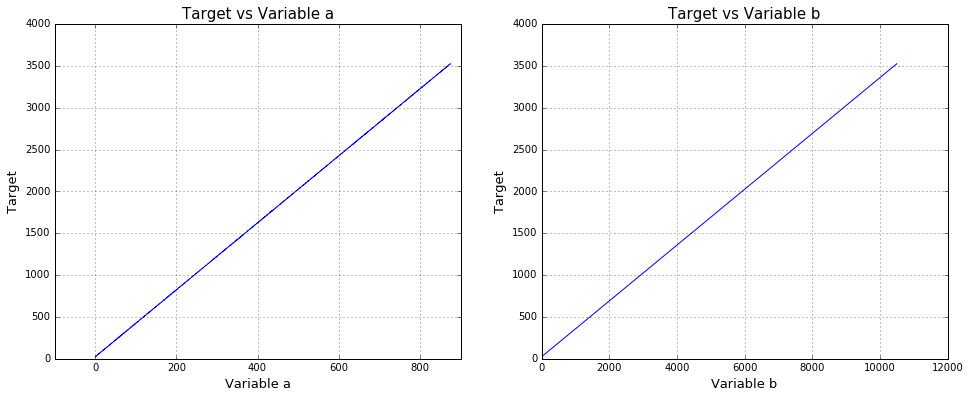

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=[16, 6])

ax[0].plot(X.values[:, :1], y)
ax[0].set_ylabel("Target", fontsize="13")
ax[0].set_xlabel("Variable a", fontsize="13")
ax[0].set_title("Target vs Variable a", fontsize="15")
ax[0].grid(True)

ax[1].plot(X.values[:, 1:], y)
ax[1].set_ylabel("Target", fontsize="13")
ax[1].set_xlabel("Variable b", fontsize="13")
ax[1].set_title("Target vs Variable b", fontsize="15")
ax[1].grid(True)
plt.show()

Jak widać zmienna targetowa (y) jest wysyko skorelowana zarówno ze zmienną a jak i b:

In [10]:
# Wysoka korelacja między zmiennymi niezależnymi a i b
pearsonr(X.values[:, :1], X.values[:, 1:])

(array([ 0.9999995]), array([ 0.]))

Niestety, zmienne a i b są także wysoko skorelowane między sobą:

In [11]:
# Oraz między nimi i zmienną targetową
pearsonr(X.values[:, :1], y)

(array([ 0.9999995]), array([ 0.]))

Na razie to zignoruję, chcę zobaczyc jak regresja sobie z tym poradzi:

In [12]:
lm = LinearRegression().fit(X, y)

print("Regresja liniowa wyestymowała następujące wagi: \nWa = %s, \nWb = %s, \nIntercept = %s"
      % (str(lm.coef_[0][0]), str(lm.coef_[0][1]), str(lm.intercept_[0])))

Regresja liniowa wyestymowała następujące wagi: 
Wa = 0.052325134557, 
Wb = 0.328972560635, 
Intercept = 25.0024579113


In [13]:
print("R square = %.16f" % lm.score(X, y))

R square = 0.9999999872147637


In [14]:
y_prediction = lm.predict(X)
MSE = mean_squared_error(y_true = y, y_pred = y_prediction)
RMSE = sqrt(MSE)

print("MSE = %s, RMSE = %s" % (MSE, RMSE))

MSE = 0.0130514582805, RMSE = 0.11424297913013871


### Rozkład reszt i wykresy błędów w zależności od wartości przewidywanej:

In [94]:
errors = (y_prediction - y).values
SE = errors**2
SE.shape

(3500, 1)

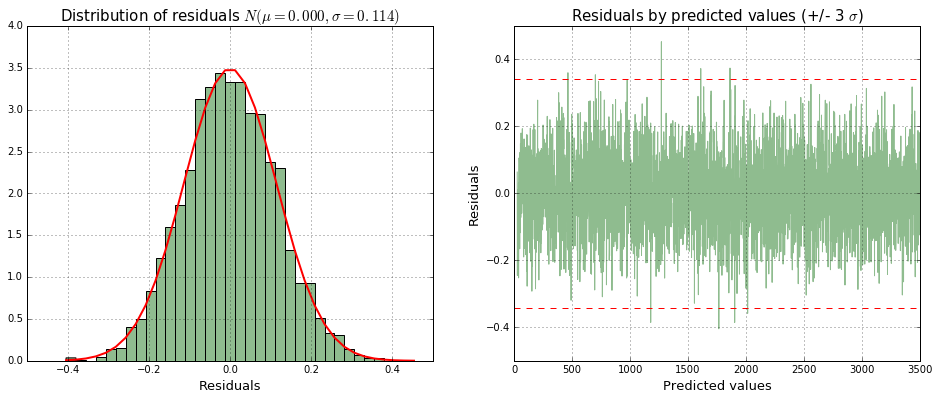

In [143]:
mu = errors.mean()
sigma = errors.std()

fig, ax = plt.subplots(1, 2, figsize=[16, 6])

n, bins, patches = ax[0].hist(errors, bins=35, normed=True, color="darkseagreen")
ax[0].plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *  np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
ax[0].set_xlim(-0.50, 0.50)
ax[0].set_ylim(0, 4.0)
ax[0].set_title(r"Distribution of residuals $N(\mu=%.3f, \sigma=%.3f)$" % (mu, sigma), fontsize="15")
ax[0].set_xlabel("Residuals", fontsize="13")
ax[0].grid(True)

ax[1].plot(y_prediction, errors, color="darkseagreen")
ax[1].set_xlim(0, 3500)
ax[1].set_xlabel("Predicted values", fontsize="13")
ax[1].set_ylabel("Residuals", fontsize="13")
ax[1].set_title("Residuals by predicted values (+/- 3 $\sigma$)", fontsize="15")
ax[1].axhline(y=errors.std()*3, linewidth=1, color='r', linestyle="--")
ax[1].axhline(y=-errors.std()*3, linewidth=1, color='r', linestyle="--")
ax[1].grid(True)
plt.show()

Reszty, zdają się mieć rozkład normalny ze średnią i dominantą w okolicy zera. Nie widać żadnych zależności dla wartości reszt i predykcji (w całym zakresie predykcji reszty wyglądają na przypadkowe). Dobre dopasowanie modelu potwierdza także bardzo niska i nieistotna korelacja reszt z wartościami przewidywanymi: 

In [96]:
pearsonr(y_prediction, SE)

(array([-0.00844676]), array([ 0.61739389]))

## 2. Metoda z użyciem pseudoinwersji macierzy Moore'a-Penrose'a 

Na podstawie podstawowych operacji na macierzach / algebra liniowa:<br>
Poniewarz macierz X ze zmiennymi niezależnymi nie jest prawidłową macierzą z punktu widzenia matematyki, nie będzie miała inwersji i nie można użyć standardowej metody do rozwiązania układu równań liniowych o postaci:
$\vec{y} = A^{-1} \cdot \vec{b}$. Ponieważ pseudoinwersja macierzy Moore'a-Penrose'a spełnia warunek $A \cdot A^+ \approx I$, to macierz $A^+$ będzie maksymalnie zbliżona do $A^{-1}$ co pozwoli obliczyć estymowany wektor współczynników kierunkowych regresji $\hat{y} $ i będzie minimalizowała błąd. Zatem:

$$\hat{y} = A^{+} \cdot \vec{b}$$

Należy pamiętać, aby <b>dodać kolejną kolumnę z 1</b> - to będzie potrzebne aby obliczyć współczynnik dla Intercept, gdyż oryginalnie w macierzy A są tylko kolumny dla zmiennych a i b podczas gdy pełne równanie to:

$$Target = Wa \cdot zmienna\_a + Wb \cdot zmienna\_b + 1 \cdot Intercept$$

I właśnie dla tego $1 \cdot Intercept$ dodaję kolumnę jedynek.
<br>Dla ułatwienia korzystam z np.ones() i pd.assign(nowa_zmienna = ....) a następnie konwertuję X do array.

In [98]:
A = np.array(X.assign(intercept = np.ones(X.shape[0])))
print(A[:5])
print("Shape: %s" % str(A.shape))

[[  0.13390087   3.90458096   1.        ]
 [ -0.05651711   5.43744991   1.        ]
 [  0.58143905   8.12319888   1.        ]
 [  1.21885296  10.92177939   1.        ]
 [  1.05020603  15.25138672   1.        ]]
Shape: (3500, 3)


In [99]:
A_plus = np.linalg.pinv(A)
#print("Macierz pseudoinwersji po przekształceniu: \n %s" % str(A_plus))
A_plus.shape

(3, 3500)

<br>
Obliczenie współczynników w Python<br>
macierz pseudoinwersji otrzymujemy za pomocą np.linalg.piv(A)
Następnie obliczamy estymatory jako iloczyn macierzy A_plus i wektora ze zmienną target (tu oznaczenie b): $\hat{y} = A^+ \cdot \vec{b}$

In [100]:
estimator_values = np.linalg.pinv(A).dot(y)
estimator_values

array([[  0.05232513],
       [  0.32897256],
       [ 25.00245791]])

In [101]:
print("Oszacowania przy pomocy macierzy pseudoinwersji Moore'a i Penrose'a:\nWa = %s, \nWb = %s, \nIntercept: %s"
      % (estimator_values[0], estimator_values[1], estimator_values[2]))
print("\nPonieważ współczynniki są te same co dała regresja liniowa, miary błędów również będą takie same:")
print("MSE = %s, RMSE = %s" % (MSE, RMSE))

Oszacowania przy pomocy macierzy pseudoinwersji Moore'a i Penrose'a:
Wa = [ 0.05232513], 
Wb = [ 0.32897256], 
Intercept: [ 25.00245791]

Ponieważ współczynniki są te same co dała regresja liniowa, miary błędów również będą takie same:
MSE = 0.0130514582805, RMSE = 0.11424297913013871


## Oraz najlepszy wynik dla algorytmu Algen:

<span style="color: green;">
[*] Najlepsze dopasowanie to: WA = 0.0000, WB = 0.3333, intercept = 24.9450, mse = 0.0142, residual standard error = 0.1190<br>
</span>
Czyli algen całkiem nieźle "odgadł" prawdziwe współczynniki stosując ewolucyjne podejście i losowe mutacje najlepszych rozwiązań


### Bonus: Singular Value Decomposition (SVD)

Jako, że nie jest to macież kwadratowa, to nie można policzyć eigenvectors i eigenvalues jak przy macierzy korelacji na przykład. Dlatego SVD, co także daje podobne efekty: left singular matrix, singular value vector, right singular matrix:

$$A = U \cdot diag(d) \cdot V^{-1}$$

In [102]:
# UWAGA!
# W pythonie macierz V jest już odwrócona, więc przy obliczaniu spowrotem A nie trzeba jej odwracać! 
U, d, V = np.linalg.svd(A)

In [103]:
A

array([[  1.33900875e-01,   3.90458096e+00,   1.00000000e+00],
       [ -5.65171053e-02,   5.43744991e+00,   1.00000000e+00],
       [  5.81439054e-01,   8.12319888e+00,   1.00000000e+00],
       ..., 
       [  8.74484510e+02,   1.04944779e+04,   1.00000000e+00],
       [  8.74609906e+02,   1.04966604e+04,   1.00000000e+00],
       [  8.75324866e+02,   1.05003135e+04,   1.00000000e+00]])

In [104]:
# Rekonstrukcja oryginalnej macierzy za pomocą wszystkich "3 głównych składowych"
U[:, :3].dot(np.diag(d[:3])).dot(V[:3, :])

array([[  1.33900875e-01,   3.90458096e+00,   1.00000000e+00],
       [ -5.65171053e-02,   5.43744991e+00,   1.00000000e+00],
       [  5.81439054e-01,   8.12319888e+00,   1.00000000e+00],
       ..., 
       [  8.74484510e+02,   1.04944779e+04,   1.00000000e+00],
       [  8.74609906e+02,   1.04966604e+04,   1.00000000e+00],
       [  8.75324866e+02,   1.05003135e+04,   1.00000000e+00]])

In [105]:
# Rekonstrukcja oryginalnej macierzy za pomocą tylko "2 pierwszych głównych składowych"
U[:, :2].dot(np.diag(d[:2])).dot(V[:2, :])

array([[  3.35956249e-01,   3.88774335e+00,   9.97572650e-01],
       [  4.61453408e-01,   5.39428657e+00,   9.93777470e-01],
       [  6.88176358e-01,   8.11430429e+00,   9.98717734e-01],
       ..., 
       [  8.74533961e+02,   1.04944738e+04,   9.99405932e-01],
       [  8.74715431e+02,   1.04966516e+04,   9.98732289e-01],
       [  8.75022743e+02,   1.05003387e+04,   1.00362949e+00]])

<br>
<br>
W sumie SVD jest wykorzystywane do obliczania nie tylko głównych składowych ale i do macierzy Moore'a Penrose'a (pseudo inwersja macierzy A):

$$A^+ = V \cdot D^+ \cdot U^T$$


Inny sposób, bez SVD ale <b>mniej dokładny</b> to:

$$
A^+ = (A^T \cdot A)^{-1} \cdot A^T
$$

<br>Mniej dokłady sposób bez SVD wtym przypadku daje jednak takie same rezultaty:

In [106]:
# W A mamy już columnę z 1
A_plus2 = np.linalg.inv(A.T.dot(A)).dot(A.T)

# Wynik (wektor)
A_plus2.dot(y)

array([[  0.05232514],
       [  0.32897256],
       [ 25.00245791]])

In [107]:
np.trace(A)

6.5713507847758024

In [108]:
np.linalg.det(A[:A.shape[1], :])

-1.4893180813782589

In [109]:
A.shape

(3500, 3)